In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
import pickle
import utils
from collections import defaultdict
from tqdm.notebook import tqdm
def load_pickle(filename):
    with open(filename, 'rb') as f:
        return pickle.load(f)

In [5]:
# Change these 
training_data_dir = "./data/training_data/training_data_filtered/training_data/v2.2"
split_dir = "./data/training_data/training_data_filtered/training_data/splits/v2"

In [6]:
def get_split_files(split_name):
    with open(os.path.join(split_dir, f"{split_name}.txt"), 'r') as f:
        prefix = [os.path.join(training_data_dir, line.strip()) for line in f if line.strip()]
        rgb = [p + "_color_kinect.png" for p in prefix]
        depth = [p + "_depth_kinect.png" for p in prefix]
        label = [p + "_label_kinect.png" for p in prefix]
        meta = [p + "_meta.pkl" for p in prefix]
    return rgb, depth, label, meta

In [7]:
rgb_files, depth_files, label_files, meta_files = get_split_files('val')

In [8]:
from matplotlib.cm import get_cmap
NUM_OBJECTS = 79
cmap = get_cmap('rainbow', NUM_OBJECTS)
COLOR_PALETTE = np.array([cmap(i)[:3] for i in range(NUM_OBJECTS + 3)])
COLOR_PALETTE = np.array(COLOR_PALETTE * 255, dtype=np.uint8)
COLOR_PALETTE[-3] = [119, 135, 150]
COLOR_PALETTE[-2] = [176, 194, 216]
COLOR_PALETTE[-1] = [255, 255, 225]

## Get familiar with the data

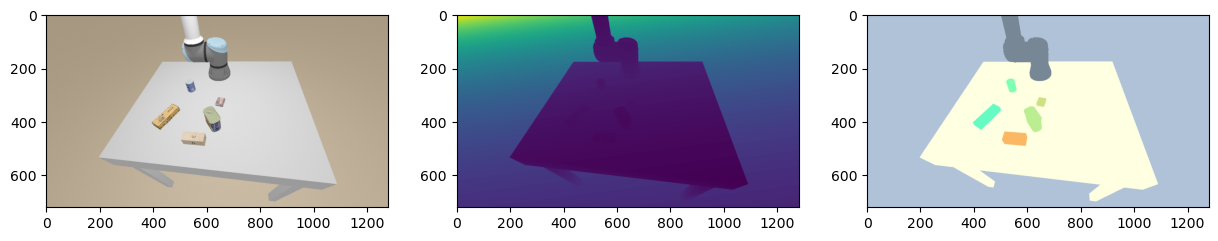

In [9]:
rgb = np.array(Image.open(rgb_files[0])) / 255   # convert 0-255 to 0-1
depth = np.array(Image.open(depth_files[0])) / 1000   # convert from mm to m
label = np.array(Image.open(label_files[0]))
plt.figure(figsize=(15, 10))
plt.subplot(1, 3, 1)
plt.imshow(rgb)
plt.subplot(1, 3, 2)
plt.imshow(depth)
plt.subplot(1, 3, 3)
plt.imshow(COLOR_PALETTE[label])  # draw colorful segmentation

In [7]:
meta = load_pickle(meta_files[0])
meta.keys()

dict_keys(['poses_world', 'extents', 'scales', 'object_ids', 'object_names', 'extrinsic', 'intrinsic'])

In [8]:
meta['object_names'], meta['object_ids']

(['jenga', 'master_chef_can', 'potted_meat_can', 'pudding_box', 'wood_block'],
 array([35, 39, 48, 51, 58]))

In [9]:
poses_world = np.array([meta['poses_world'][idx] for idx in meta['object_ids']])
box_sizes = np.array([meta['extents'][idx] * meta['scales'][idx] for idx in meta['object_ids']])

## Lift depth to point cloud

In [10]:
intrinsic = meta['intrinsic']
z = depth
v, u = np.indices(z.shape)
uv1 = np.stack([u + 0.5, v + 0.5, np.ones_like(z)], axis=-1)
points_viewer = uv1 @ np.linalg.inv(intrinsic).T * z[..., None]  # [H, W, 3]

In [11]:
import open3d
points = open3d.utility.Vector3dVector(points_viewer.reshape([-1, 3]))
colors = open3d.utility.Vector3dVector(rgb.reshape([-1, 3]))
pcd = open3d.geometry.PointCloud()
pcd.points = points
pcd.colors = colors
open3d.visualization.draw_geometries([pcd])
# will open another window to show the point cloud

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


# Creating Pickle

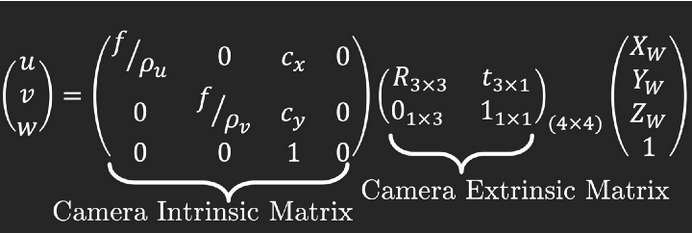

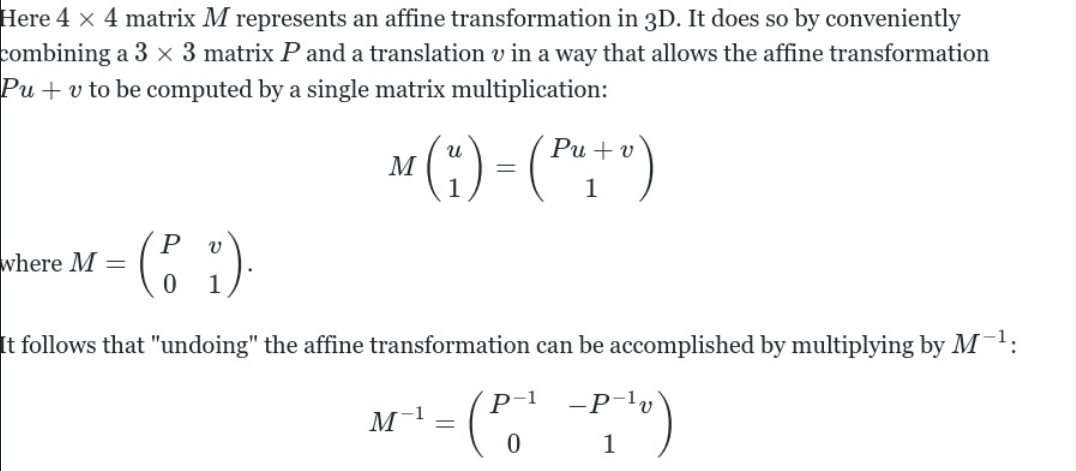

In [ ]:
def display_3d(points_viewer):
    points = open3d.utility.Vector3dVector(points_viewer.reshape([-1, 3]))
    colors = open3d.utility.Vector3dVector(rgb.reshape([-1, 3]))
    pcd = open3d.geometry.PointCloud()
    pcd.points = points
    pcd.colors = colors
    open3d.visualization.draw_geometries([pcd])


ImportError: cannot import name 'JVisualizer' from 'open3d' (/opt/anaconda3/lib/python3.9/site-packages/open3d/__init__.py)

In [13]:
def point_cloud_image_in_c(meta,depth):
    intrinsic = meta['intrinsic']
    z = depth
    v, u = np.indices(z.shape)
    uv1 = np.stack([u + 0.5, v + 0.5, np.ones_like(z)], axis=-1)
    points_viewer = uv1 @ np.linalg.inv(intrinsic).T * z[..., None]  # [H, W, 3]
    return(points_viewer)

In [15]:
rgb_files, depth_files, label_files, meta_files = get_split_files('train')
point_cloud_dict = defaultdict(list)
for meta_file,depth_file,label_file in tqdm(zip(meta_files,depth_files,label_files),total=len(meta_files)):
    depth = np.array(Image.open(depth_file)) / 1000   # convert from mm to m
    meta = load_pickle(meta_file)
    label = np.array(Image.open(label_file))
    pc_image = point_cloud_image_in_c(meta,depth)
    extrinsic = meta['extrinsic']
    extr_inv = np.linalg.inv(extrinsic)
    # inv_Rext = np.linalg.inv(extrinsic[:3,:3])
    # # inv_Rext = extrinsic[:3,:3].T
    # inv_text = -inv_Rext@extrinsic[:3,3]
    for objind in meta['object_ids']:
        seg_pcd = pc_image[label==objind]
        # seg_pcd_world = (seg_pcd@inv_Rext.T)+inv_text
        # seg_pcd_world = (np.column_stack((seg_pcd,np.ones(seg_pcd.shape[0])))@extr_inv.T)[:,:3]
        # seg_pcd_world = ((np.column_stack((seg_pcd,np.ones(seg_pcd.shape[0]))))@extr_inv)[:,:3]
        seg_pcd_world = seg_pcd@ extr_inv[:3, :3].T + extr_inv[:3, 3]
        
        world_pose = meta['poses_world'][objind]
        # inv_Rpose = np.linalg.inv(world_pose[:3,:3])
        # # inv_Rpose = world_pose[:3,:3].T
        # inv_tpose = np.squeeze(-inv_Rpose@world_pose[:3,3])
        pose_inv = np.linalg.inv(world_pose)
        # seg_pcd_base = (seg_pcd_world@inv_Rpose.T)+inv_tpose
        # seg_pcd_base = ((np.column_stack((seg_pcd_world,np.ones(seg_pcd_world.shape[0]))))@pose_inv.T)[:,:3]
        # seg_pcd_base = (pose_inv@(np.column_stack((seg_pcd_world,np.ones(seg_pcd_world.shape[0]))).T)).T[:,:3]
        seg_pcd_base = seg_pcd_world@ pose_inv[:3, :3].T + pose_inv[:3, 3]
        
        point_cloud_dict[objind].append(seg_pcd_base)
    

  0%|          | 0/3964 [00:00<?, ?it/s]

In [16]:
with open('obj_pcd_dict.pickle', 'wb') as handle:
    pickle.dump(point_cloud_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

# ICP Validation

In [21]:
import pickle
import open3d
from pathlib import Path
from operator import attrgetter
from benchmark_utils import pose_utils
import json

def np2o3d(points_viewer):
    # points = open3d.utility.Vector3dVector(points_viewer.reshape([-1, 3]))
    colors = open3d.utility.Vector3dVector(rgb.reshape([-1, 3]))
    points = open3d.utility.Vector3dVector(points_viewer.reshape([-1, 3]))
    pcd = open3d.geometry.PointCloud()
    pcd.points = points
    pcd.colors = colors
    return pcd


In [1]:
point_cloud_dict = load_pickle("obj_pcd_dict.pickle")

NameError: name 'load_pickle' is not defined

In [22]:
display_3d(np.vstack(point_cloud_dict[list(point_cloud_dict.keys())[0]]))

In [58]:
rgb_files, depth_files, label_files, meta_files = get_split_files('val')

In [216]:
depth = np.array(Image.open(depth_files[0])) / 1000   # convert from mm to m
meta = load_pickle(meta_files[0])
label = np.array(Image.open(label_files[0]))
pc_image = point_cloud_image_in_c(meta,depth)
extrinsic = meta['extrinsic']
extr_inv = np.linalg.inv(extrinsic)
seg_pcd = pc_image[label==35]
seg_pcd_world = seg_pcd@ extr_inv[:3, :3].T + extr_inv[:3, 3]
# T = get_best_transform(seg_pcd,objind)

# d = point_cloud_dict[35]
# test = [open3d.pipelines.registration.registration_icp(np2o3d(tr_pcd),np2o3d(seg_pcd_world),0.2) for tr_pcd in tqdm(d)]

In [23]:
from sklearn.decomposition import PCA
from scipy.spatial.transform import Rotation as R

def align_rotation_matrix(vec1, vec2):
    """get rotation matrix between two vectors using scipy
    vec1->source
    vec2->target
    """
    vec1 = np.reshape(vec1, (1, -1))
    vec2 = np.reshape(vec2, (1, -1))
    r = R.align_vectors(vec2, vec1)
    return r[0].as_matrix()

def rot_align_via_PCA(src,tgt):
    try:
        pca = PCA(n_components=3)
        pca.fit(src)
        eig_vec = pca.components_
        normal_src = eig_vec[2, :] 
        pca = PCA(n_components=3)
        pca.fit(tgt)
        eig_vec = pca.components_
        normal_tgt = eig_vec[2, :] 
        return(align_rotation_matrix(normal_src, normal_tgt))
    except:
        return(np.eye(3))
    


In [24]:
def get_best_transform(pcd,obj,skip = 64,train_red_factor = 1):
    registrationResults = []
    init_t = np.eye(4)
    for pcd_tr in tqdm(point_cloud_dict[obj][::train_red_factor],leave=False):
        pcd_tr = pcd_tr[::skip]
        # pcd = pcd[::skip]
        shift = (np.mean(pcd,0)-np.mean(pcd_tr,0))
        init_t[:3,3] = shift
        init_t[:3,:3] = rot_align_via_PCA(pcd_tr,pcd)
        tmp = open3d.pipelines.registration.registration_icp(np2o3d(pcd_tr),
                                                             np2o3d(pcd),
                                                     0.2,init_t)        
        registrationResults.append([len(tmp.correspondence_set),tmp.inlier_rmse,tmp.transformation])
    registrationResults = np.array(registrationResults,dtype=object)
    if(not(np.all(registrationResults[:,0]==0))):
        registrationResults = registrationResults[np.squeeze(np.argwhere(registrationResults[:,0]!=0))]
    registrationResults = registrationResults[np.argsort(-registrationResults[:,0])[:len(registrationResults)//5]]
    T = np.copy(registrationResults[np.argmin(registrationResults[:,1])][2])
    # print(T,registrationResults[np.argmin(registrationResults[:,1])],registrationResults)
    # T[:3,3]+=shift
    return(T)


In [25]:
def draw_bb(poses_world,meta,rgb):
    box_sizes = np.array([meta['extents'][idx] * meta['scales'][idx] for idx in meta['object_ids']])
    boxed_image = np.array(rgb)
    for i in range(len(poses_world)):
        utils.draw_projected_box3d(
            boxed_image, poses_world[i][:3,3], box_sizes[i], poses_world[i][:3, :3], meta['extrinsic'], meta['intrinsic'],
            thickness=2)
    # plt.plot(Image.fromarray((boxed_image * 255).astype(np.uint8)))
    return(Image.fromarray((boxed_image * 255).astype(np.uint8)))


In [26]:
# from multiprocessing import Pool
# import multiprocessing

# def get_solution(depth_file,meta_file,label_file,rgb_file,validation_ans,SKIP,TRAIN_RED_FACTOR,IMSHOW):
#     print(depth_file)
#     depth = np.array(Image.open(depth_file)) / 1000   # convert from mm to m
#     meta = load_pickle(meta_file)
#     label = np.array(Image.open(label_file))
#     rgb = np.array(Image.open(rgb_file)) / 255   # convert 0-255 to 0-1
#     pc_image = point_cloud_image_in_c(meta,depth)
#     extrinsic = meta['extrinsic']
#     extr_inv = np.linalg.inv(extrinsic)
#     im_name = Path(meta_file).name.split('_')[0]
#     validation_ans[Path(meta_file).name.split('_')[0]] = {'poses_world':[None]*79}
#     for objind in tqdm(meta['object_ids'],leave=False):
#         seg_pcd = pc_image[label==objind]
#         seg_pcd_world = seg_pcd@ extr_inv[:3, :3].T + extr_inv[:3, 3]
#         T = get_best_transform(seg_pcd_world,objind,SKIP,TRAIN_RED_FACTOR)
#         # T[:3,:3]*=-1
#         validation_ans[Path(meta_file).name.split('_')[0]]['poses_world'][objind] = T.tolist()
#     plt.figure(figsize=(20,20))
#     if(IMSHOW):
#         plt.imshow(np.hstack([
#             np.array(draw_bb(np.array([validation_ans[im_name]['poses_world'][idx] for idx in meta['object_ids']]),meta,rgb)),
#             np.array(draw_bb(np.array([meta['poses_world'][idx] for idx in meta['object_ids']]),meta,rgb))
#         ]))

In [27]:
# validation_ans = {}
# SKIP=80
# IMSHOW = True
# TRAIN_RED_FACTOR = 10
# anyxind = np.random.randint(0,len(meta_files),1)
# for meta_file,depth_file,label_file,rgb_file in tqdm(zip(np.array(meta_files)[anyxind],
#                                                 np.array(depth_files)[anyxind],
#                                                 np.array(label_files)[anyxind],
#                                                np.array(rgb_files)[anyxind]),total=len(np.array(meta_files)[anyxind])):
#     get_solution(depth_file,meta_file,label_file,rgb_file,validation_ans,SKIP,TRAIN_RED_FACTOR,IMSHOW)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/257 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/159 [00:00<?, ?it/s]

  0%|          | 0/279 [00:00<?, ?it/s]

  0%|          | 0/278 [00:00<?, ?it/s]

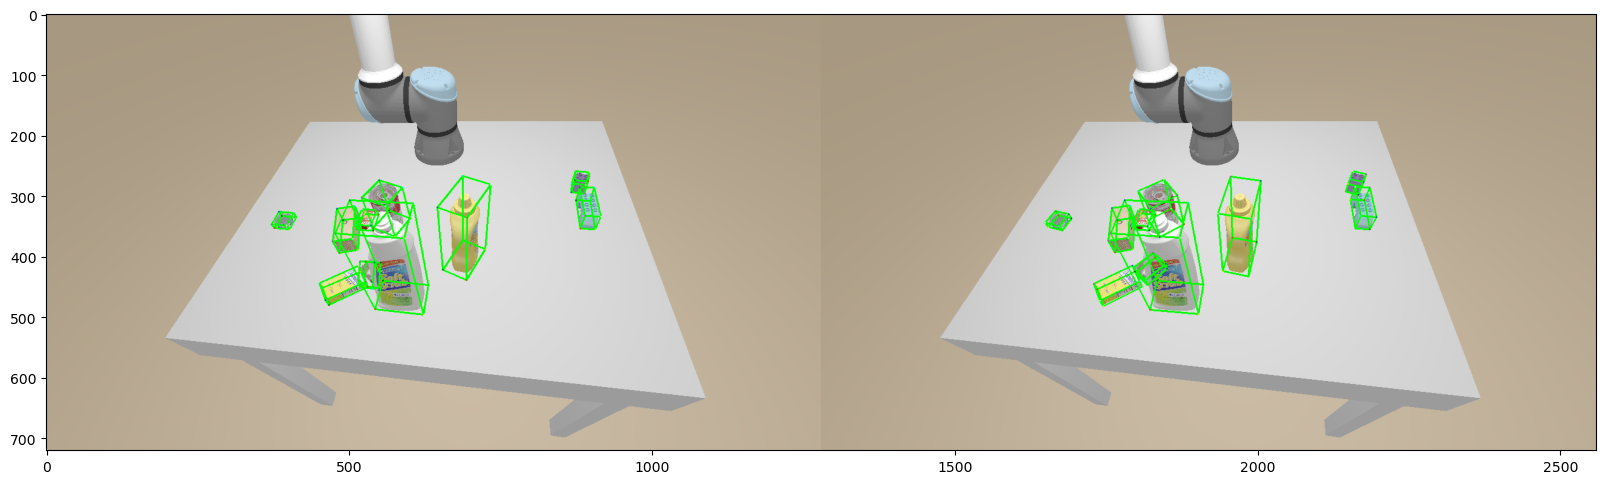

In [28]:
from IPython.core.debugger import set_trace
import warnings
warnings.filterwarnings('ignore')
validation_ans = {}
SKIP=64
IMSHOW = True
TRAIN_RED_FACTOR = 10
anyxind = np.random.randint(0,len(meta_files),1)
for meta_file,depth_file,label_file,rgb_file in tqdm(zip(np.array(meta_files)[anyxind],
                                                np.array(depth_files)[anyxind],
                                                np.array(label_files)[anyxind],
                                               np.array(rgb_files)[anyxind]),total=len(np.array(meta_files)[anyxind])):
    depth = np.array(Image.open(depth_file)) / 1000   # convert from mm to m
    meta = load_pickle(meta_file)
    label = np.array(Image.open(label_file))
    rgb = np.array(Image.open(rgb_file)) / 255   # convert 0-255 to 0-1
    pc_image = point_cloud_image_in_c(meta,depth)
    extrinsic = meta['extrinsic']
    extr_inv = np.linalg.inv(extrinsic)
    im_name = Path(meta_file).name.split('_')[0]
    validation_ans[Path(meta_file).name.split('_')[0]] = {'poses_world':[None]*79}
    for objind in tqdm(meta['object_ids'],leave=False):
        seg_pcd = pc_image[label==objind]
        seg_pcd_world = seg_pcd@ extr_inv[:3, :3].T + extr_inv[:3, 3]
        T = get_best_transform(seg_pcd_world,objind,SKIP,TRAIN_RED_FACTOR)
        # T[:3,:3]*=-1
        validation_ans[Path(meta_file).name.split('_')[0]]['poses_world'][objind] = T.tolist()
    plt.figure(figsize=(20,20))
    if(IMSHOW):
        plt.imshow(np.hstack([
            np.array(draw_bb(np.array([validation_ans[im_name]['poses_world'][idx] for idx in meta['object_ids']]),meta,rgb)),
            np.array(draw_bb(np.array([meta['poses_world'][idx] for idx in meta['object_ids']]),meta,rgb))
        ]))

with open('validation/val_pred.json', 'w') as f:
    json.dump(validation_ans, f, ensure_ascii=False)
with open('validation/baseline.json', 'r') as f:
    val_gt = json.load(f)
with open('validation/val_gt.json', 'w') as f:
    gt = {}
    for k in validation_ans:
        gt[k] = val_gt[k]
    json.dump(gt, f, ensure_ascii=False)

In [92]:
with open('validation/baseline.json', 'r') as f:
    val_gt = json.load(f)
with open('validation/val_gt.json', 'w') as f:
    gt = {}
    for k in validation_ans:
        gt[k] = val_gt[k]
    json.dump(gt, f, ensure_ascii=False)

## Draw bounding boxes of poses on 2D image
If you are curious, take a look at `utils.py`. It is very simple.

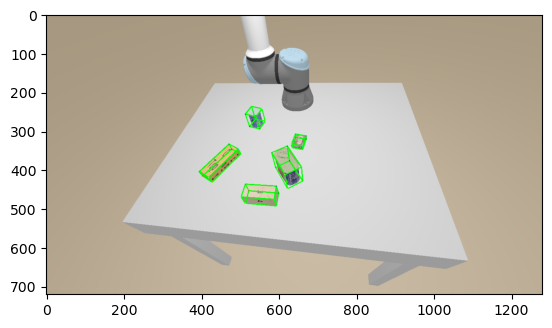

In [231]:
boxed_image = np.array(rgb)
for i in range(len(poses_world)):
    utils.draw_projected_box3d(
        boxed_image, poses_world[i][:3,3], box_sizes[i], poses_world[i][:3, :3], meta['extrinsic'], meta['intrinsic'],
        thickness=2)

plt.imshow(Image.fromarray((boxed_image * 255).astype(np.uint8)))

## Test data
Test data has everything but the poses. Testing data and training data are from the same distribution.

In [277]:
load_pickle("./data/testing_data_pose/testing_data_pose_filtered/testing_data/v2.2/1-1-1_meta.pkl").keys()

dict_keys(['extents', 'scales', 'object_ids', 'object_names', 'extrinsic', 'intrinsic'])

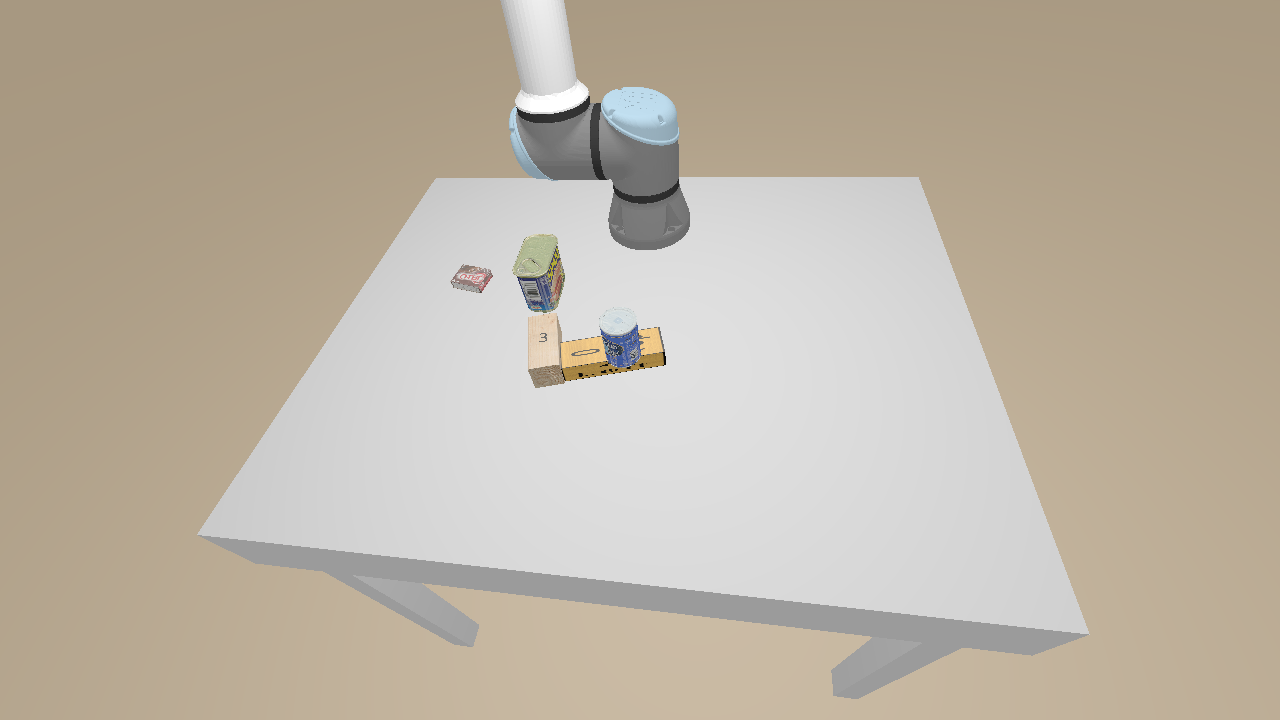

In [278]:
Image.open("./data/testing_data_pose/testing_data_pose_filtered/testing_data/v2.2/1-1-1_color_kinect.png")

## Testing

In [89]:
testing_data_dir = "./data/testing_data_pose/testing_data_pose_filtered/testing_data/v2.2"
split_dir = "./data/training_data/training_data_filtered/training_data/splits/v2"

In [90]:
with open("./data/testing_data_pose/testing_data_pose_filtered/testing_data/test.txt",'r') as f:
    prefix = [os.path.join(testing_data_dir, line.strip()) for line in f if line.strip()]
    rgb_test_files = [p + "_color_kinect.png" for p in prefix]
    depth_test_files = [p + "_depth_kinect.png" for p in prefix]
    label_test_files = [p + "_label_kinect.png" for p in prefix]
    meta_test_files= [p + "_meta.pkl" for p in prefix]

    

In [ ]:
test_ans = {}
SKIP=64
IMSHOW = False
TRAIN_RED_FACTOR = 1
for meta_file,depth_file,label_file,rgb_file in tqdm(zip(np.array(meta_test_files),
                                                np.array(depth_test_files),
                                                np.array(label_test_files),
                                               np.array(rgb_test_files)),total=len(np.array(meta_test_files))):
    depth = np.array(Image.open(depth_file)) / 1000   # convert from mm to m
    meta = load_pickle(meta_file)
    label = np.array(Image.open(label_file))
    rgb = np.array(Image.open(rgb_file)) / 255   # convert 0-255 to 0-1
    pc_image = point_cloud_image_in_c(meta,depth)
    extrinsic = meta['extrinsic']
    extr_inv = np.linalg.inv(extrinsic)
    im_name = Path(meta_file).name.split('_')[0]
    test_ans[Path(meta_file).name.split('_')[0]] = {'poses_world':[None]*79}
    for objind in tqdm(meta['object_ids'],leave=False):
        seg_pcd = pc_image[label==objind]
        seg_pcd_world = seg_pcd@ extr_inv[:3, :3].T + extr_inv[:3, 3]
        T = get_best_transform(seg_pcd_world,objind,SKIP,TRAIN_RED_FACTOR)
        # T[:3,:3]*=-1
        test_ans[Path(meta_file).name.split('_')[0]]['poses_world'][objind] = T.tolist()
    plt.figure(figsize=(20,20))
    if(IMSHOW):
        plt.imshow(np.array(draw_bb(np.array([test_ans[im_name]['poses_world'][idx] for idx in meta['object_ids']]),meta,rgb)))
        plt.show()

with open('test/test_pred.json', 'w') as f:
    json.dump(test_ans, f, ensure_ascii=False)
# with open('validation/baseline.json', 'r') as f:
#     val_gt = json.load(f)
# with open('validation/val_gt.json', 'w') as f:
#     gt = {}
#     for k in validation_ans:
#         gt[k] = val_gt[k]
#     json.dump(gt, f, ensure_ascii=False)

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1777 [00:00<?, ?it/s]

  0%|          | 0/1970 [00:00<?, ?it/s]

  0%|          | 0/1584 [00:00<?, ?it/s]

  0%|          | 0/2562 [00:00<?, ?it/s]

  0%|          | 0/2779 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1777 [00:00<?, ?it/s]

  0%|          | 0/1970 [00:00<?, ?it/s]

  0%|          | 0/1584 [00:00<?, ?it/s]

  0%|          | 0/2562 [00:00<?, ?it/s]

  0%|          | 0/2779 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1777 [00:00<?, ?it/s]

  0%|          | 0/1970 [00:00<?, ?it/s]

  0%|          | 0/1584 [00:00<?, ?it/s]

  0%|          | 0/2562 [00:00<?, ?it/s]

  0%|          | 0/2779 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1777 [00:00<?, ?it/s]

  0%|          | 0/1970 [00:00<?, ?it/s]

  0%|          | 0/1584 [00:00<?, ?it/s]

  0%|          | 0/2562 [00:00<?, ?it/s]

  0%|          | 0/2779 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1777 [00:00<?, ?it/s]

  0%|          | 0/1970 [00:00<?, ?it/s]

  0%|          | 0/1584 [00:00<?, ?it/s]

  0%|          | 0/2562 [00:00<?, ?it/s]

  0%|          | 0/2779 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1777 [00:00<?, ?it/s]

  0%|          | 0/1970 [00:00<?, ?it/s]

  0%|          | 0/1584 [00:00<?, ?it/s]

  0%|          | 0/2562 [00:00<?, ?it/s]

  0%|          | 0/2779 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1777 [00:00<?, ?it/s]

  0%|          | 0/1970 [00:00<?, ?it/s]

  0%|          | 0/1584 [00:00<?, ?it/s]

  0%|          | 0/2562 [00:00<?, ?it/s]

  0%|          | 0/2779 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1777 [00:00<?, ?it/s]

  0%|          | 0/1970 [00:00<?, ?it/s]

  0%|          | 0/1584 [00:00<?, ?it/s]

  0%|          | 0/2562 [00:00<?, ?it/s]

  0%|          | 0/2779 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1777 [00:00<?, ?it/s]

  0%|          | 0/1970 [00:00<?, ?it/s]

  0%|          | 0/1584 [00:00<?, ?it/s]

  0%|          | 0/2562 [00:00<?, ?it/s]

  0%|          | 0/2779 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1777 [00:00<?, ?it/s]

  0%|          | 0/1970 [00:00<?, ?it/s]

  0%|          | 0/1584 [00:00<?, ?it/s]

  0%|          | 0/2562 [00:00<?, ?it/s]

  0%|          | 0/2779 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1970 [00:00<?, ?it/s]

  0%|          | 0/2562 [00:00<?, ?it/s]

  0%|          | 0/998 [00:00<?, ?it/s]

  0%|          | 0/2784 [00:00<?, ?it/s]

  0%|          | 0/2779 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1970 [00:00<?, ?it/s]

  0%|          | 0/2562 [00:00<?, ?it/s]

  0%|          | 0/998 [00:00<?, ?it/s]

  0%|          | 0/2784 [00:00<?, ?it/s]

  0%|          | 0/2779 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1970 [00:00<?, ?it/s]

  0%|          | 0/2562 [00:00<?, ?it/s]

  0%|          | 0/998 [00:00<?, ?it/s]

  0%|          | 0/2784 [00:00<?, ?it/s]

  0%|          | 0/2779 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1970 [00:00<?, ?it/s]

  0%|          | 0/2562 [00:00<?, ?it/s]

  0%|          | 0/998 [00:00<?, ?it/s]

  0%|          | 0/2784 [00:00<?, ?it/s]

  0%|          | 0/2779 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1970 [00:00<?, ?it/s]

  0%|          | 0/2562 [00:00<?, ?it/s]

  0%|          | 0/998 [00:00<?, ?it/s]

  0%|          | 0/2784 [00:00<?, ?it/s]

  0%|          | 0/2779 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1970 [00:00<?, ?it/s]

  0%|          | 0/2562 [00:00<?, ?it/s]

  0%|          | 0/998 [00:00<?, ?it/s]

  0%|          | 0/2784 [00:00<?, ?it/s]

  0%|          | 0/2779 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1970 [00:00<?, ?it/s]

  0%|          | 0/2562 [00:00<?, ?it/s]

  0%|          | 0/998 [00:00<?, ?it/s]

  0%|          | 0/2784 [00:00<?, ?it/s]

  0%|          | 0/2779 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1970 [00:00<?, ?it/s]

  0%|          | 0/2562 [00:00<?, ?it/s]

  0%|          | 0/998 [00:00<?, ?it/s]

  0%|          | 0/2784 [00:00<?, ?it/s]

  0%|          | 0/2779 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1970 [00:00<?, ?it/s]

  0%|          | 0/2562 [00:00<?, ?it/s]

  0%|          | 0/998 [00:00<?, ?it/s]

  0%|          | 0/2784 [00:00<?, ?it/s]

  0%|          | 0/2779 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1970 [00:00<?, ?it/s]

  0%|          | 0/2562 [00:00<?, ?it/s]

  0%|          | 0/998 [00:00<?, ?it/s]

  0%|          | 0/2784 [00:00<?, ?it/s]

  0%|          | 0/2779 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1792 [00:00<?, ?it/s]

  0%|          | 0/2562 [00:00<?, ?it/s]

  0%|          | 0/1795 [00:00<?, ?it/s]

  0%|          | 0/1590 [00:00<?, ?it/s]

  0%|          | 0/2784 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1792 [00:00<?, ?it/s]

  0%|          | 0/2562 [00:00<?, ?it/s]

  0%|          | 0/1795 [00:00<?, ?it/s]

  0%|          | 0/1590 [00:00<?, ?it/s]

  0%|          | 0/2784 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1792 [00:00<?, ?it/s]

  0%|          | 0/2562 [00:00<?, ?it/s]

  0%|          | 0/1795 [00:00<?, ?it/s]

  0%|          | 0/1590 [00:00<?, ?it/s]

  0%|          | 0/2784 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1792 [00:00<?, ?it/s]

  0%|          | 0/2562 [00:00<?, ?it/s]

  0%|          | 0/1795 [00:00<?, ?it/s]

  0%|          | 0/1590 [00:00<?, ?it/s]

  0%|          | 0/2784 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1792 [00:00<?, ?it/s]

  0%|          | 0/2562 [00:00<?, ?it/s]

  0%|          | 0/1795 [00:00<?, ?it/s]

  0%|          | 0/1590 [00:00<?, ?it/s]

  0%|          | 0/2784 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1792 [00:00<?, ?it/s]

  0%|          | 0/2562 [00:00<?, ?it/s]

  0%|          | 0/1795 [00:00<?, ?it/s]

  0%|          | 0/1590 [00:00<?, ?it/s]

  0%|          | 0/2784 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1792 [00:00<?, ?it/s]

  0%|          | 0/2562 [00:00<?, ?it/s]

  0%|          | 0/1795 [00:00<?, ?it/s]

  0%|          | 0/1590 [00:00<?, ?it/s]

  0%|          | 0/2784 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1792 [00:00<?, ?it/s]

  0%|          | 0/2562 [00:00<?, ?it/s]

  0%|          | 0/1795 [00:00<?, ?it/s]

  0%|          | 0/1590 [00:00<?, ?it/s]

  0%|          | 0/2784 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1792 [00:00<?, ?it/s]

  0%|          | 0/2562 [00:00<?, ?it/s]

  0%|          | 0/1795 [00:00<?, ?it/s]

  0%|          | 0/1590 [00:00<?, ?it/s]

  0%|          | 0/2784 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1792 [00:00<?, ?it/s]

  0%|          | 0/2562 [00:00<?, ?it/s]

  0%|          | 0/1795 [00:00<?, ?it/s]

  0%|          | 0/1590 [00:00<?, ?it/s]

  0%|          | 0/2784 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2180 [00:00<?, ?it/s]

  0%|          | 0/1584 [00:00<?, ?it/s]

  0%|          | 0/2562 [00:00<?, ?it/s]

  0%|          | 0/2784 [00:00<?, ?it/s]

  0%|          | 0/2779 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2180 [00:00<?, ?it/s]

  0%|          | 0/1584 [00:00<?, ?it/s]

  0%|          | 0/2562 [00:00<?, ?it/s]

  0%|          | 0/2784 [00:00<?, ?it/s]

  0%|          | 0/2779 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2180 [00:00<?, ?it/s]

  0%|          | 0/1584 [00:00<?, ?it/s]

  0%|          | 0/2562 [00:00<?, ?it/s]

  0%|          | 0/2784 [00:00<?, ?it/s]

  0%|          | 0/2779 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2180 [00:00<?, ?it/s]

  0%|          | 0/1584 [00:00<?, ?it/s]

  0%|          | 0/2562 [00:00<?, ?it/s]

  0%|          | 0/2784 [00:00<?, ?it/s]

  0%|          | 0/2779 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2180 [00:00<?, ?it/s]

  0%|          | 0/1584 [00:00<?, ?it/s]

  0%|          | 0/2562 [00:00<?, ?it/s]

  0%|          | 0/2784 [00:00<?, ?it/s]

  0%|          | 0/2779 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2180 [00:00<?, ?it/s]

  0%|          | 0/1584 [00:00<?, ?it/s]

  0%|          | 0/2562 [00:00<?, ?it/s]

  0%|          | 0/2784 [00:00<?, ?it/s]

  0%|          | 0/2779 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2180 [00:00<?, ?it/s]

  0%|          | 0/1584 [00:00<?, ?it/s]

  0%|          | 0/2562 [00:00<?, ?it/s]

  0%|          | 0/2784 [00:00<?, ?it/s]

  0%|          | 0/2779 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2180 [00:00<?, ?it/s]

  0%|          | 0/1584 [00:00<?, ?it/s]

  0%|          | 0/2562 [00:00<?, ?it/s]

  0%|          | 0/2784 [00:00<?, ?it/s]

  0%|          | 0/2779 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2180 [00:00<?, ?it/s]

  0%|          | 0/1584 [00:00<?, ?it/s]

  0%|          | 0/2562 [00:00<?, ?it/s]

  0%|          | 0/2784 [00:00<?, ?it/s]

  0%|          | 0/2779 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2180 [00:00<?, ?it/s]

  0%|          | 0/1584 [00:00<?, ?it/s]

  0%|          | 0/2562 [00:00<?, ?it/s]

  0%|          | 0/2784 [00:00<?, ?it/s]

  0%|          | 0/2779 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1792 [00:00<?, ?it/s]

  0%|          | 0/1970 [00:00<?, ?it/s]

  0%|          | 0/2562 [00:00<?, ?it/s]

  0%|          | 0/2784 [00:00<?, ?it/s]

  0%|          | 0/2779 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1792 [00:00<?, ?it/s]

  0%|          | 0/1970 [00:00<?, ?it/s]

  0%|          | 0/2562 [00:00<?, ?it/s]

  0%|          | 0/2784 [00:00<?, ?it/s]

  0%|          | 0/2779 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1792 [00:00<?, ?it/s]

  0%|          | 0/1970 [00:00<?, ?it/s]

  0%|          | 0/2562 [00:00<?, ?it/s]

  0%|          | 0/2784 [00:00<?, ?it/s]

  0%|          | 0/2779 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1792 [00:00<?, ?it/s]

  0%|          | 0/1970 [00:00<?, ?it/s]

  0%|          | 0/2562 [00:00<?, ?it/s]

  0%|          | 0/2784 [00:00<?, ?it/s]

  0%|          | 0/2779 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1792 [00:00<?, ?it/s]

  0%|          | 0/1970 [00:00<?, ?it/s]

  0%|          | 0/2562 [00:00<?, ?it/s]

  0%|          | 0/2784 [00:00<?, ?it/s]

  0%|          | 0/2779 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1792 [00:00<?, ?it/s]

  0%|          | 0/1970 [00:00<?, ?it/s]

  0%|          | 0/2562 [00:00<?, ?it/s]

  0%|          | 0/2784 [00:00<?, ?it/s]

  0%|          | 0/2779 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1792 [00:00<?, ?it/s]

  0%|          | 0/1970 [00:00<?, ?it/s]

  0%|          | 0/2562 [00:00<?, ?it/s]

  0%|          | 0/2784 [00:00<?, ?it/s]

  0%|          | 0/2779 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1792 [00:00<?, ?it/s]

  0%|          | 0/1970 [00:00<?, ?it/s]

  0%|          | 0/2562 [00:00<?, ?it/s]

  0%|          | 0/2784 [00:00<?, ?it/s]

  0%|          | 0/2779 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1792 [00:00<?, ?it/s]

  0%|          | 0/1970 [00:00<?, ?it/s]

  0%|          | 0/2562 [00:00<?, ?it/s]

  0%|          | 0/2784 [00:00<?, ?it/s]

  0%|          | 0/2779 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1792 [00:00<?, ?it/s]

  0%|          | 0/1970 [00:00<?, ?it/s]

  0%|          | 0/2562 [00:00<?, ?it/s]

  0%|          | 0/2784 [00:00<?, ?it/s]

  0%|          | 0/2779 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2180 [00:00<?, ?it/s]

  0%|          | 0/1777 [00:00<?, ?it/s]

  0%|          | 0/1584 [00:00<?, ?it/s]

  0%|          | 0/2562 [00:00<?, ?it/s]

  0%|          | 0/1590 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2180 [00:00<?, ?it/s]

  0%|          | 0/1777 [00:00<?, ?it/s]

  0%|          | 0/1584 [00:00<?, ?it/s]

  0%|          | 0/2562 [00:00<?, ?it/s]

  0%|          | 0/1590 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2180 [00:00<?, ?it/s]

  0%|          | 0/1777 [00:00<?, ?it/s]

  0%|          | 0/1584 [00:00<?, ?it/s]

  0%|          | 0/2562 [00:00<?, ?it/s]

  0%|          | 0/1590 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2180 [00:00<?, ?it/s]

  0%|          | 0/1777 [00:00<?, ?it/s]

  0%|          | 0/1584 [00:00<?, ?it/s]

  0%|          | 0/2562 [00:00<?, ?it/s]

  0%|          | 0/1590 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2180 [00:00<?, ?it/s]

  0%|          | 0/1777 [00:00<?, ?it/s]

  0%|          | 0/1584 [00:00<?, ?it/s]

  0%|          | 0/2562 [00:00<?, ?it/s]

  0%|          | 0/1590 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2180 [00:00<?, ?it/s]

  0%|          | 0/1777 [00:00<?, ?it/s]

  0%|          | 0/1584 [00:00<?, ?it/s]

  0%|          | 0/2562 [00:00<?, ?it/s]

  0%|          | 0/1590 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2180 [00:00<?, ?it/s]

  0%|          | 0/1777 [00:00<?, ?it/s]

  0%|          | 0/1584 [00:00<?, ?it/s]

  0%|          | 0/2562 [00:00<?, ?it/s]

  0%|          | 0/1590 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2180 [00:00<?, ?it/s]

  0%|          | 0/1777 [00:00<?, ?it/s]

  0%|          | 0/1584 [00:00<?, ?it/s]

  0%|          | 0/2562 [00:00<?, ?it/s]

  0%|          | 0/1590 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2180 [00:00<?, ?it/s]

  0%|          | 0/1777 [00:00<?, ?it/s]

  0%|          | 0/1584 [00:00<?, ?it/s]

  0%|          | 0/2562 [00:00<?, ?it/s]

  0%|          | 0/1590 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2180 [00:00<?, ?it/s]

  0%|          | 0/1777 [00:00<?, ?it/s]

  0%|          | 0/1584 [00:00<?, ?it/s]

  0%|          | 0/2562 [00:00<?, ?it/s]

  0%|          | 0/1590 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1792 [00:00<?, ?it/s]

  0%|          | 0/1584 [00:00<?, ?it/s]

  0%|          | 0/1795 [00:00<?, ?it/s]

  0%|          | 0/1590 [00:00<?, ?it/s]

  0%|          | 0/2779 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1792 [00:00<?, ?it/s]

  0%|          | 0/1584 [00:00<?, ?it/s]

  0%|          | 0/1795 [00:00<?, ?it/s]

  0%|          | 0/1590 [00:00<?, ?it/s]

  0%|          | 0/2779 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1792 [00:00<?, ?it/s]

  0%|          | 0/1584 [00:00<?, ?it/s]

  0%|          | 0/1795 [00:00<?, ?it/s]

  0%|          | 0/1590 [00:00<?, ?it/s]

  0%|          | 0/2779 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1792 [00:00<?, ?it/s]

  0%|          | 0/1584 [00:00<?, ?it/s]

  0%|          | 0/1795 [00:00<?, ?it/s]

  0%|          | 0/1590 [00:00<?, ?it/s]

  0%|          | 0/2779 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1792 [00:00<?, ?it/s]

  0%|          | 0/1584 [00:00<?, ?it/s]

  0%|          | 0/1795 [00:00<?, ?it/s]

  0%|          | 0/1590 [00:00<?, ?it/s]

  0%|          | 0/2779 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1792 [00:00<?, ?it/s]

  0%|          | 0/1584 [00:00<?, ?it/s]

  0%|          | 0/1795 [00:00<?, ?it/s]

  0%|          | 0/1590 [00:00<?, ?it/s]

  0%|          | 0/2779 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1792 [00:00<?, ?it/s]

  0%|          | 0/1584 [00:00<?, ?it/s]

  0%|          | 0/1795 [00:00<?, ?it/s]

  0%|          | 0/1590 [00:00<?, ?it/s]

  0%|          | 0/2779 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1792 [00:00<?, ?it/s]

  0%|          | 0/1584 [00:00<?, ?it/s]

  0%|          | 0/1795 [00:00<?, ?it/s]

  0%|          | 0/1590 [00:00<?, ?it/s]

  0%|          | 0/2779 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1792 [00:00<?, ?it/s]

  0%|          | 0/1584 [00:00<?, ?it/s]

  0%|          | 0/1795 [00:00<?, ?it/s]

  0%|          | 0/1590 [00:00<?, ?it/s]

  0%|          | 0/2779 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1792 [00:00<?, ?it/s]

  0%|          | 0/1584 [00:00<?, ?it/s]

  0%|          | 0/1795 [00:00<?, ?it/s]

  0%|          | 0/1590 [00:00<?, ?it/s]

  0%|          | 0/2779 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2180 [00:00<?, ?it/s]

  0%|          | 0/1970 [00:00<?, ?it/s]

  0%|          | 0/998 [00:00<?, ?it/s]

  0%|          | 0/2784 [00:00<?, ?it/s]

  0%|          | 0/2779 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2180 [00:00<?, ?it/s]

  0%|          | 0/1970 [00:00<?, ?it/s]

  0%|          | 0/998 [00:00<?, ?it/s]

  0%|          | 0/2784 [00:00<?, ?it/s]

  0%|          | 0/2779 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2180 [00:00<?, ?it/s]

  0%|          | 0/1970 [00:00<?, ?it/s]

  0%|          | 0/998 [00:00<?, ?it/s]

  0%|          | 0/2784 [00:00<?, ?it/s]

  0%|          | 0/2779 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2180 [00:00<?, ?it/s]

  0%|          | 0/1970 [00:00<?, ?it/s]

  0%|          | 0/998 [00:00<?, ?it/s]

  0%|          | 0/2784 [00:00<?, ?it/s]

  0%|          | 0/2779 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2180 [00:00<?, ?it/s]

  0%|          | 0/1970 [00:00<?, ?it/s]

  0%|          | 0/998 [00:00<?, ?it/s]

  0%|          | 0/2784 [00:00<?, ?it/s]

  0%|          | 0/2779 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2180 [00:00<?, ?it/s]

  0%|          | 0/1970 [00:00<?, ?it/s]

  0%|          | 0/998 [00:00<?, ?it/s]

  0%|          | 0/2784 [00:00<?, ?it/s]

  0%|          | 0/2779 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2180 [00:00<?, ?it/s]

  0%|          | 0/1970 [00:00<?, ?it/s]

  0%|          | 0/998 [00:00<?, ?it/s]

  0%|          | 0/2784 [00:00<?, ?it/s]

  0%|          | 0/2779 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2180 [00:00<?, ?it/s]

  0%|          | 0/1970 [00:00<?, ?it/s]

  0%|          | 0/998 [00:00<?, ?it/s]

  0%|          | 0/2784 [00:00<?, ?it/s]

  0%|          | 0/2779 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2180 [00:00<?, ?it/s]

  0%|          | 0/1970 [00:00<?, ?it/s]

  0%|          | 0/998 [00:00<?, ?it/s]

  0%|          | 0/2784 [00:00<?, ?it/s]

  0%|          | 0/2779 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2180 [00:00<?, ?it/s]

  0%|          | 0/1970 [00:00<?, ?it/s]

  0%|          | 0/998 [00:00<?, ?it/s]

  0%|          | 0/2784 [00:00<?, ?it/s]

  0%|          | 0/2779 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2180 [00:00<?, ?it/s]

  0%|          | 0/2562 [00:00<?, ?it/s]

  0%|          | 0/1590 [00:00<?, ?it/s]

  0%|          | 0/2784 [00:00<?, ?it/s]

  0%|          | 0/2779 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2180 [00:00<?, ?it/s]

  0%|          | 0/2562 [00:00<?, ?it/s]

  0%|          | 0/1590 [00:00<?, ?it/s]

  0%|          | 0/2784 [00:00<?, ?it/s]

  0%|          | 0/2779 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2180 [00:00<?, ?it/s]

  0%|          | 0/2562 [00:00<?, ?it/s]

  0%|          | 0/1590 [00:00<?, ?it/s]

  0%|          | 0/2784 [00:00<?, ?it/s]

  0%|          | 0/2779 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2180 [00:00<?, ?it/s]

  0%|          | 0/2562 [00:00<?, ?it/s]

  0%|          | 0/1590 [00:00<?, ?it/s]

  0%|          | 0/2784 [00:00<?, ?it/s]

  0%|          | 0/2779 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2180 [00:00<?, ?it/s]

  0%|          | 0/2562 [00:00<?, ?it/s]

  0%|          | 0/1590 [00:00<?, ?it/s]

  0%|          | 0/2784 [00:00<?, ?it/s]

  0%|          | 0/2779 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2180 [00:00<?, ?it/s]

  0%|          | 0/2562 [00:00<?, ?it/s]

In [299]:
with open('test/test_pred.json', 'w') as f:
    json.dump(test_ans, f, ensure_ascii=False)
